In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/data/VidyaAnalytics_HRAnalytics/

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/data/VidyaAnalytics_HRAnalytics


In [ ]:
# Imports

!pip install scikit-learn==0.24.1 category_encoders
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas import DataFrame
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import time
import string
import re
from scipy import sparse
from joblib import Parallel

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score,r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.fixes import delayed
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

     |████████████████████████████████| 22.3MB 66.0MB/s 
     |████████████████████████████████| 81kB 7.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
# Function to plot numeric variables

def plot_numerical(data,numerical_var,target_var):
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,6))
  fig.tight_layout(pad=5.0)

  sns.distplot(data[numerical_var], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}, ax=axes[0])
  
  data[numerical_var].dropna().plot(kind = "box", ax = axes[1]) #, figsize = (20,10)

  sns.boxplot(x=target_var, y=numerical_var, data=data, ax=axes[2],showfliers = False)

In [ ]:
df = pd.read_csv("train_set.csv")
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [ ]:
df.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
1%,795.070000,1.000000,23.000000,1.000000,1.000000,0.000000,0.000000,44.000000,0.000000
10%,7849.700000,1.000000,27.000000,1.000000,2.000000,0.000000,0.000000,48.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
90%,70459.300000,2.000000,46.000000,5.000000,11.000000,1.000000,0.000000,83.000000,0.000000


In [ ]:
# Checking null percentage
df.isnull().mean().sort_values(ascending = False)*100

previous_year_rating    7.524449
education               4.395344
is_promoted             0.000000
avg_training_score      0.000000
awards_won?             0.000000
KPIs_met >80%           0.000000
length_of_service       0.000000
age                     0.000000
no_of_trainings         0.000000
recruitment_channel     0.000000
gender                  0.000000
region                  0.000000
department              0.000000
employee_id             0.000000
dtype: float64

In [ ]:
# Dropping "employee_id"
df1 = df.drop("employee_id",axis = 1)

# Mapping male as 1 and female as 0
df1["gender"] = df1["gender"].map({"m":1, "f":0})

##Bivariate Analysis
###Checking the proportion of the target variable ("is_promoted") for each categorical variable

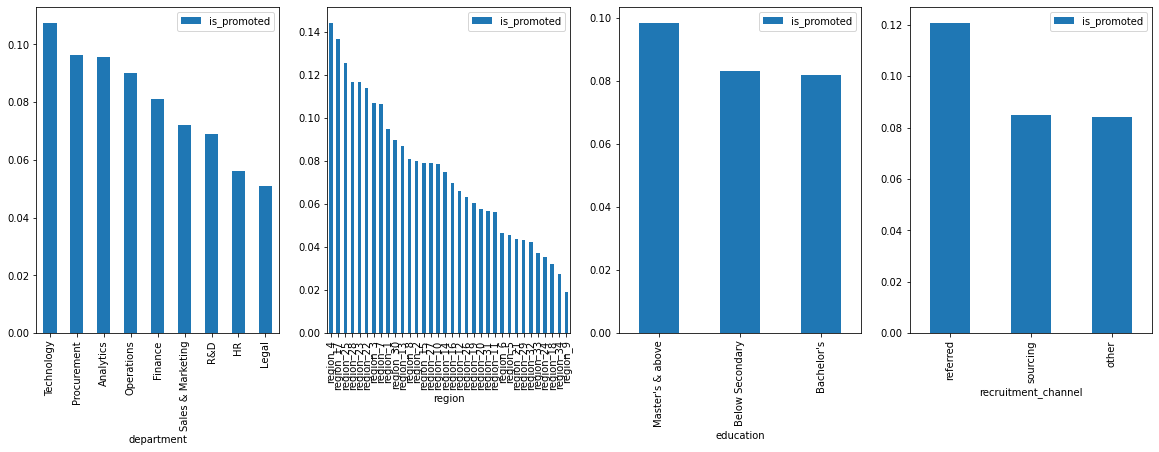

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(1,4,1)
df1.groupby("department").agg({"is_promoted": "mean"}).sort_values('is_promoted', ascending=False).plot(kind = "bar", ax = ax1)
ax2 = plt.subplot(1,4,2)
df1.groupby("region").agg({"is_promoted": "mean"}).sort_values('is_promoted', ascending=False).plot(kind = "bar", ax = ax2)
ax3 = plt.subplot(1,4,3)
df1.groupby("education").agg({"is_promoted": "mean"}).sort_values('is_promoted', ascending=False).plot(kind = "bar", ax = ax3)
ax4 = plt.subplot(1,4,4)
df1.groupby("recruitment_channel").agg({"is_promoted": "mean"}).sort_values('is_promoted', ascending=False).plot(kind = "bar", ax = ax4)

[Text(0, 0.5, ''), Text(0.5, 1.0, 'gender')]

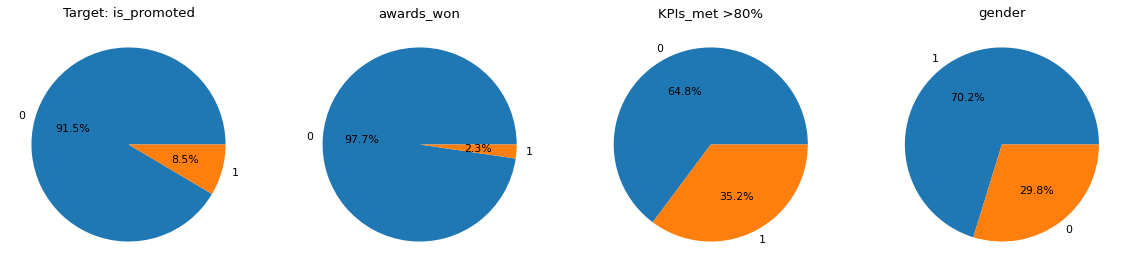

In [ ]:
# Plotting pie chart to show the proportion of binary variables

plt.figure(figsize=(20,6))
plt.subplot(1,4,1)
plt.rcParams.update({'font.size': 11})
cx = df1["is_promoted"].value_counts().plot(kind = "pie", autopct='%1.1f%%')
cx.set(title = "Target: is_promoted", ylabel = "")
plt.subplot(1,4,2)
ax = df1["awards_won?"].value_counts().plot(kind = "pie", autopct='%1.1f%%')
ax.set(title = "awards_won", ylabel = "")
plt.subplot(1,4,3)
bx = df1["KPIs_met >80%"].value_counts().plot(kind = "pie", autopct='%1.1f%%')
bx.set(title = "KPIs_met >80%", ylabel = "")
plt.subplot(1,4,4)
dx = df1["gender"].value_counts().plot(kind = "pie", autopct='%1.1f%%')
dx.set(title = "gender", ylabel = "")



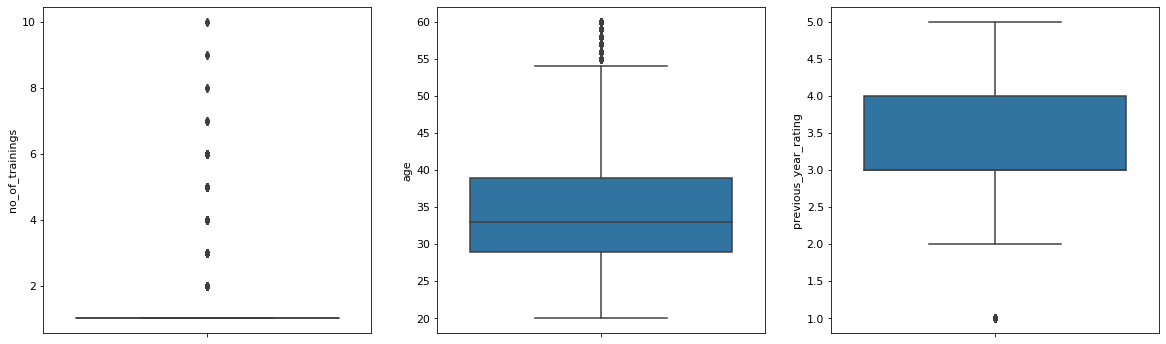

In [ ]:
# Visualising numeric variables and checking for outliers
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.boxplot( y = "no_of_trainings", data = df1)
plt.subplot(1,3,2)
sns.boxplot( y = "age", data = df1)
plt.subplot(1,3,3)
sns.boxplot( y = "previous_year_rating", data = df1)

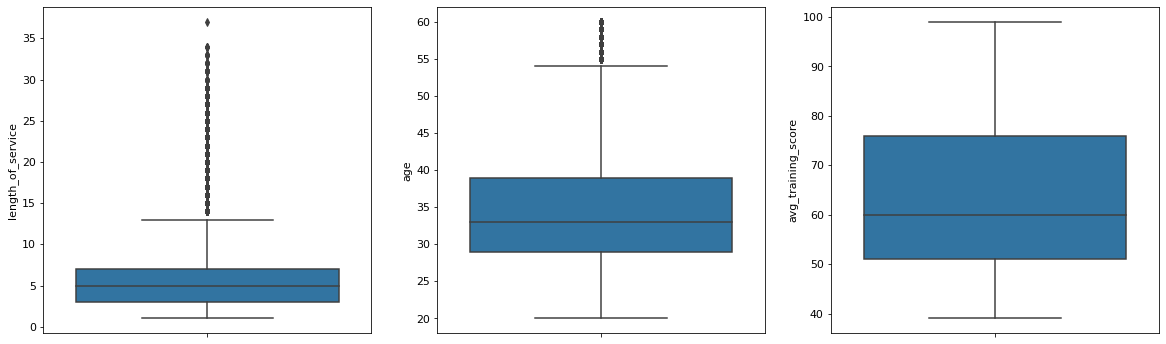

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.boxplot( y = "length_of_service", data = df1)
plt.subplot(1,3,2)
sns.boxplot( y = "age", data = df1)
plt.subplot(1,3,3)
sns.boxplot( y = "avg_training_score", data = df1)

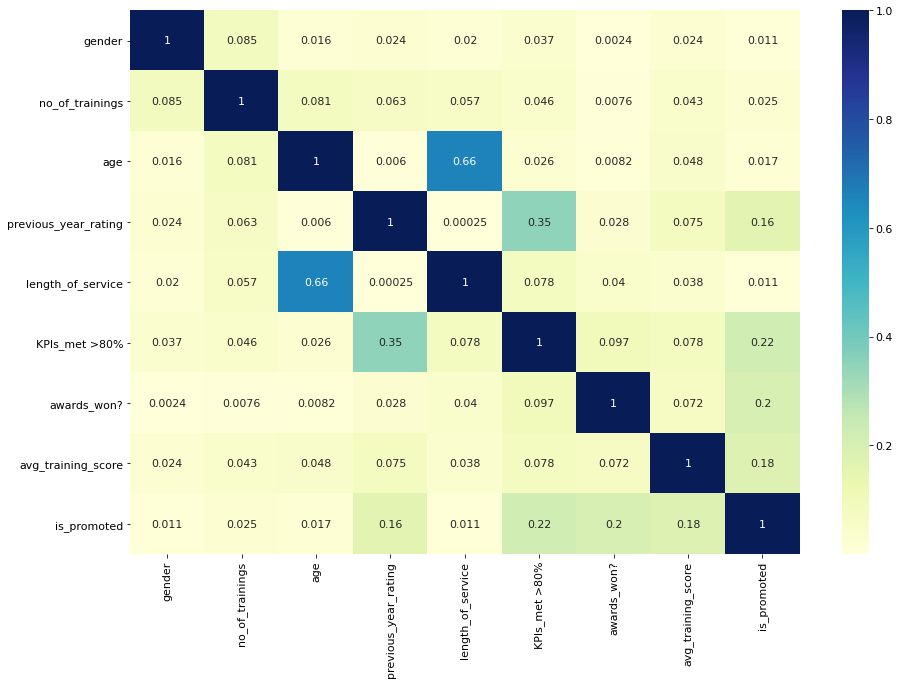

In [ ]:
# Correlation heat map

plt.figure(figsize = (15, 10))
sns.heatmap(abs(df1.corr()), annot = True, cmap="YlGnBu")
plt.show()

We cannot see highly correlated variables here

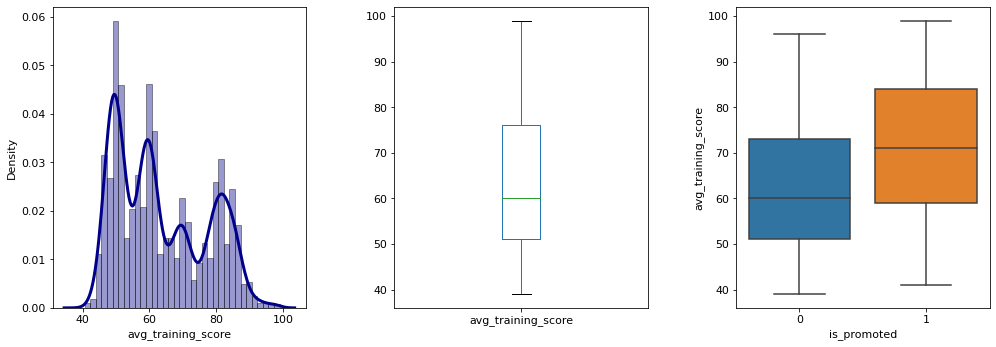

In [ ]:
plot_numerical(df1,'avg_training_score','is_promoted')

People who are promoted have higher average training score compared to those who are not promoted

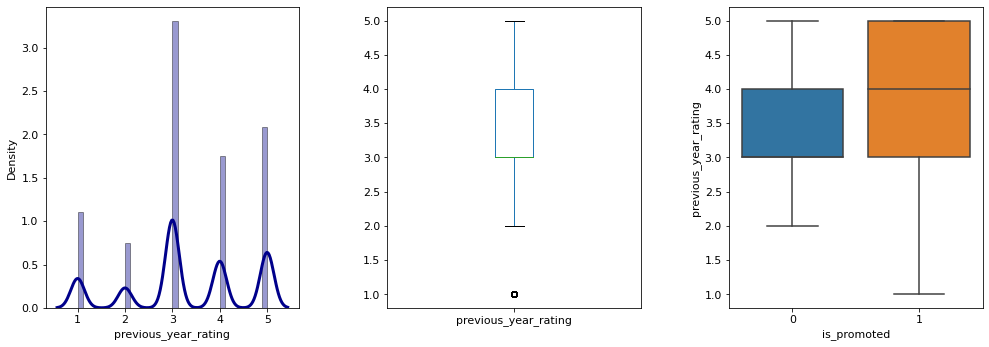

In [ ]:
plot_numerical(df1,'previous_year_rating','is_promoted')

People who are promoted have higher previous year rating compared to those who are not promoted

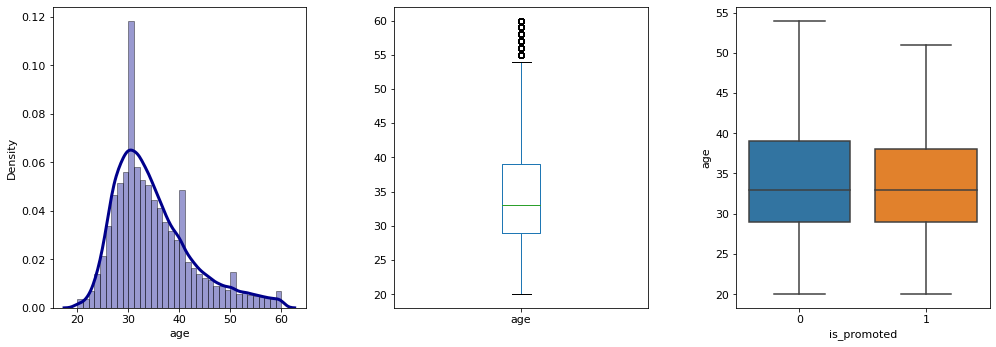

In [ ]:
plot_numerical(df1,'age','is_promoted')

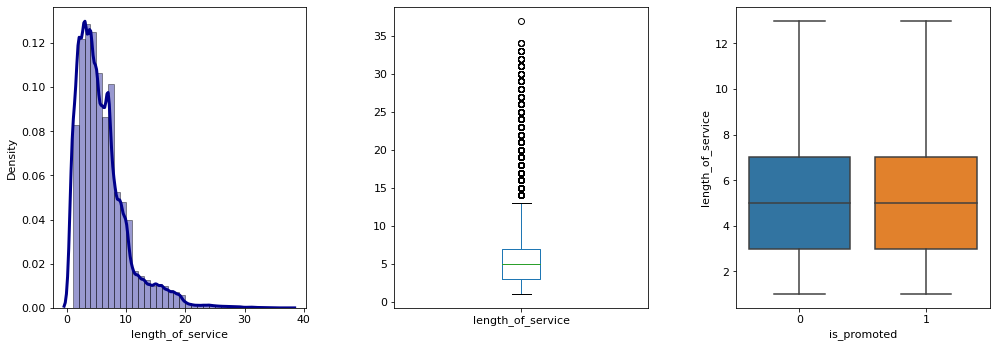

In [ ]:
plot_numerical(df1,'length_of_service','is_promoted')

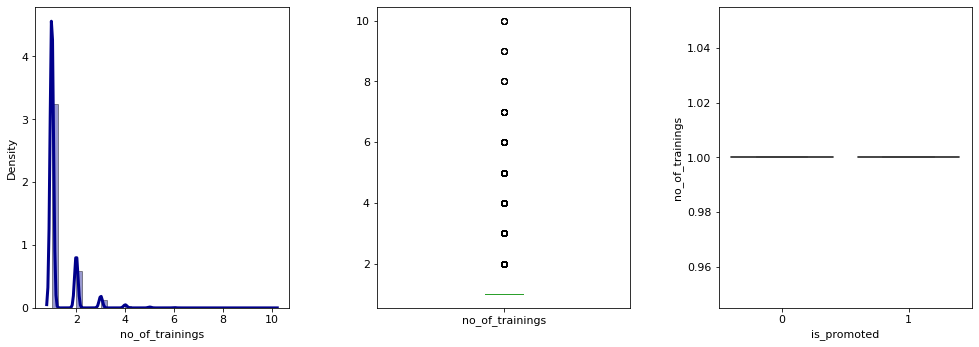

In [ ]:
plot_numerical(df1,'no_of_trainings','is_promoted')

# Fin!